**IMFDB Face Database** 

In the Google Collab setup we are going to read the binary image file uploaded from local system as reading and processing files individually from Google Drive is very slow. 

**Install keras as Collob may allocate a different VM for a new session - **

In [0]:
!pip install -q keras

In [2]:
import numpy as np
import pandas as pd
import argparse
import errno
import scipy.misc
import cv2
from skimage.feature import hog
import os
from os import listdir
from os.path import isfile, join
from os import walk
import glob
import sys
import dlib
import pickle
import codecs
import PIL
from skimage import io
from skimage import color
%config IPCompleter.greedy=True
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


**Mount the google drive in Collab - **

In [3]:

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/"

 all_data.txt	    FilePaths_DLib.txt	    'Projects_List (1).gsheet'
'Colab Notebooks'   FilePaths.txt	     Projects_List.gsheet
 face.data	    IMFDB_final_Sample	    'shadab cv_detailed.docx'
 face.data_DLib     NewImagePrediction	     Texcell_case.twbx
 face_site.data     Practicum3_IMFDB.ipynb


**Read the images dataset from the exported file and images from a binary file uploaded from local system along with the file paths -**

In [0]:
all_data = pd.read_csv('/content/drive/My Drive/all_data.txt', header=None)
all_data.columns = ('Image_Name','MovieName','Gender','FaceExpression', 'Pose')

In [0]:
def getFiles(FilePaths, ImgFilePath):
  Face_FilePaths = np.loadtxt(fname = FilePaths, dtype='str')
  with open(ImgFilePath, 'rb') as filehandle:  
      # read the data as binary data stream
    resized_grey_face = pickle.load(filehandle)
  return Face_FilePaths, resized_grey_face

In [0]:
Face_FilePaths, resized_grey_face = getFiles('/content/drive/My Drive/FilePaths.txt', '/content/drive/My Drive/face_site.data')

#plt.imshow(resized_grey_face[0]*255,cmap='gray')
#plt.show()

In [8]:
all_data.head()

,Image_Name,MovieName,Gender,FaceExpression,Pose
0,AamirKhan_1.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT
1,AamirKhan_10.jpg,AndazApnaApna,MALE,NEUTRAL,FRONTAL
2,AamirKhan_100.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT
3,AamirKhan_101.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT
4,AamirKhan_102.jpg,AndazApnaApna,MALE,NEUTRAL,RIGHT


**Divide the dataset into training and test (70% - 30%) -**

In [0]:
classes = all_data.FaceExpression.unique().tolist()
num_classes = len(all_data.FaceExpression.unique())
batch_size = 256
def splitFiles(FrontOnly):  
  x_train, y_train, x_test, y_test = [], [], [], []
  totallength = len(resized_grey_face)
  if (FrontOnly):
    splitfraction = round(0.45*(all_data[all_data.Pose == 'FRONTAL']).shape[0],0)
  else:
    splitfraction = 0.5*totallength
  splitcounter= 0
  for i in range(totallength):
    emotiontxt = ""
    try:
        filepath = Face_FilePaths[i]
        splits = filepath.split("/")
        imagename= splits[len(splits)-1]
        Moviename = splits[len(splits)-3]
        #print(filepath)
        if(FrontOnly):
          row = all_data.loc[(all_data['Image_Name'] == imagename) & (all_data['MovieName'] == Moviename) & (all_data['Pose'] == 'FRONTAL')]
          if(not row.empty):
            emotiontxt = row.iloc[0]['FaceExpression']
        else:
          row = all_data.loc[(all_data['Image_Name'] == imagename) & (all_data['MovieName'] == Moviename)]
          if(not row.empty):
            emotiontxt = row.iloc[0]['FaceExpression']         
        if(emotiontxt):
          emotionindx=classes.index(emotiontxt)
          emotion = keras.utils.to_categorical(emotionindx, num_classes)
          splitcounter = splitcounter + 1 
          if(splitcounter < splitfraction):
              y_train.append(emotion)
              x_train.append(resized_grey_face[i])
          else:
              y_test.append(emotion)
              x_test.append(resized_grey_face[i])
    except:
          print(filepath)
      #print(emotion)
      #emotion = dfrow.iloc[0]['A']

  x_train = np.array(x_train, 'float32')
  y_train = np.array(y_train, 'float32')
  x_test = np.array(x_test, 'float32')
  y_test = np.array(y_test, 'float32')

  #x_train /= 255 
  #x_test /= 255

  x_train = x_train.reshape(x_train.shape[0], 100, 100, 1)
  x_train = x_train.astype('float32')
  x_test = x_test.reshape(x_test.shape[0], 100, 100, 1)
  x_test = x_test.astype('float32')
  return x_train, y_train, x_test, y_test

In [0]:
x_train, y_train, x_test, y_test = splitFiles(FrontOnly = False)

In [11]:
print(len(y_train))
print(len(x_train))
print(len(y_test))
print(len(x_test))

14310
14310
3828
3828


**Build the CNN model to be used - **

In [0]:
#CNN Model built manually for training
def buildmodel(): 
  mdl = Sequential()
  #1st CONV layer
  mdl.add(Conv2D(64, (5, 5), activation='relu', input_shape=(100,100,1)))
  mdl.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

  #2nd CONV layer
  mdl.add(Conv2D(64, (3, 3), activation='relu'))
  mdl.add(Conv2D(64, (3, 3), activation='relu'))
  mdl.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

  #3rd CONV layer
  mdl.add(Conv2D(128, (3, 3), activation='relu'))
  mdl.add(Conv2D(128, (3, 3), activation='relu'))
  mdl.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

  mdl.add(Flatten())

  #fully connected layers
  mdl.add(Dense(1024, activation='relu'))
  mdl.add(Dropout(0.2))
  mdl.add(Dense(1024, activation='relu'))
  mdl.add(Dropout(0.2))

  mdl.add(Dense(num_classes, activation='softmax'))
  return mdl

**Run training for 10 Epochs (1 Epoch is a full run of complete dataset once forward and backwords) -**

After running for 10 Epochs we we have seen training accuracy climb rapidly after 5 Epochs suggestive of overfitting, so its suggested to run till 6 Epochs only.

In [26]:
model = buildmodel()
epochs = 4
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
 
model.compile(loss='categorical_crossentropy'
, optimizer=keras.optimizers.Adam()
, metrics=['accuracy']
)
 
model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs)

Epoch 1/4
256/256 [==============================] - 79s 308ms/step - loss: 1.7176 - acc: 0.3249
Epoch 2/4
256/256 [==============================] - 77s 301ms/step - loss: 1.6813 - acc: 0.3342
Epoch 3/4
256/256 [==============================] - 77s 300ms/step - loss: 1.6293 - acc: 0.3719
Epoch 4/4
256/256 [==============================] - 77s 299ms/step - loss: 1.4934 - acc: 0.4424


**Evaluate model on train and test dataset and print training and test accuracy -**

From train and test accuracy we can see that we have overfiltting.

In [14]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.02532802189004417
Train accuracy: 99.28721174004193
Test loss: 4.775314109119155
Test accuracy: 37.19958202716823


In [15]:
predicted_list = []; actuals_list = []
predictions = model.predict(x_test)
for i in predictions:
  predicted_list.append(np.argmax(i))
 
for i in y_test:
  actuals_list.append(np.argmax(i))
 
print(classes)
confusion_matrix(actuals_list, predicted_list)

['NEUTRAL', 'SURPRISE', 'HAPPINESS', 'ANGER', 'DISGUST', 'FEAR', 'SADNESS']


array([[652,  42, 180,  61,  81,   4,  89],
       [ 88,  23,  20,  13,  14,   1,  28],
       [365,  33, 569,  42,  54,   5,  57],
       [168,  15,  81,  43,  27,   3,  25],
       [243,  24, 115,  32,  45,   3,  37],
       [ 20,   3,  12,   5,   5,   2,  10],
       [198,  17, 126,  22,  34,   2,  90]])

**Our test accuracy of appx. 36% is not very high and we believe its largely due to the fact that a lot of the images  also have side poses which does not show full face making expression detection difficult and we could try to use face detection library to consider images with full face visible in present model  (using dlib library) or manually select images with full face only.**

**Also Disgust and Anger are close classes in terms of expression making classification more complex**

In [0]:
def analyze(emotions):
  y_pos = np.arange(len(classes))

  plt.bar(y_pos, emotions, align='center', alpha=0.5)
  plt.xticks(y_pos, classes)
  plt.ylabel('percentage')
  plt.title('emotion')

  plt.show()

In [17]:
classes

['NEUTRAL', 'SURPRISE', 'HAPPINESS', 'ANGER', 'DISGUST', 'FEAR', 'SADNESS']

In [0]:
def score(img_path):
  img = image.load_img(img_path, color_mode = "grayscale", target_size=(100, 100))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)  
  x /= 255 
  
  custom = model.predict(x)
  analyze(custom[0])

  x = np.array(x, 'float32')
  x = x.reshape([100, 100]);

  plt.gray()
  plt.imshow(x)
  plt.show()       

**Lets use our model to score new data - **

Scoring Happy


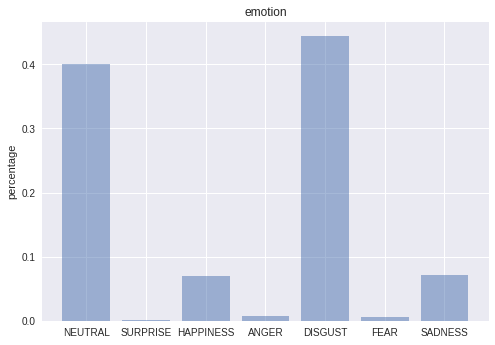

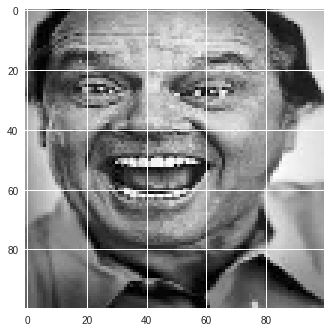

Scoring Angry


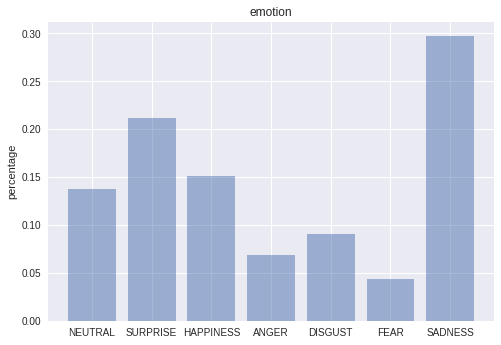

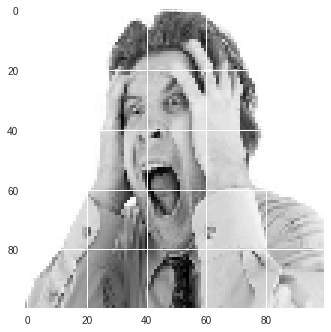

Scoring Happy


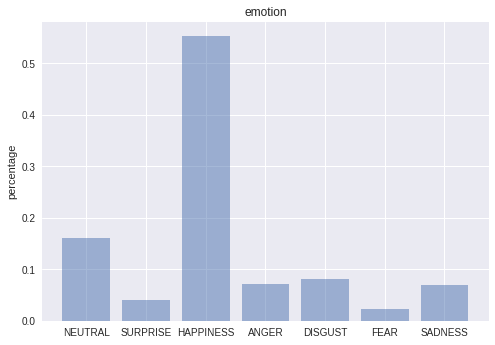

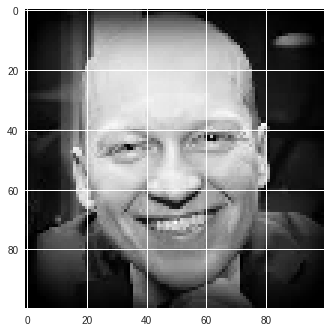

Scoring Sad


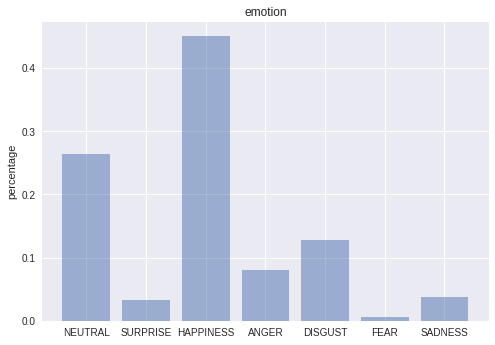

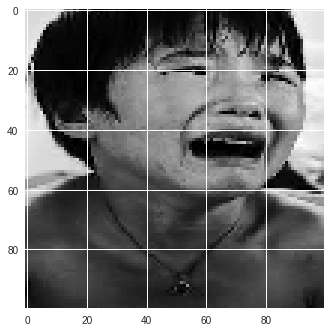

Scoring Angry


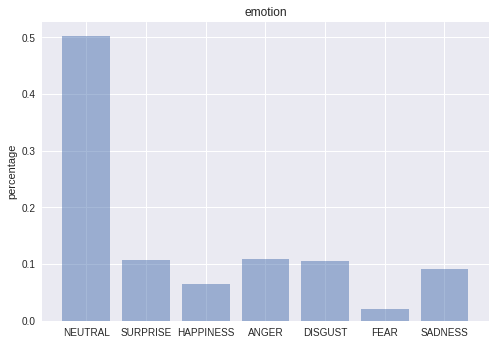

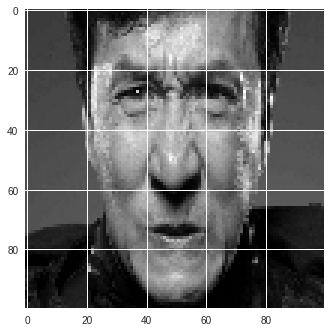

Scoring Sad


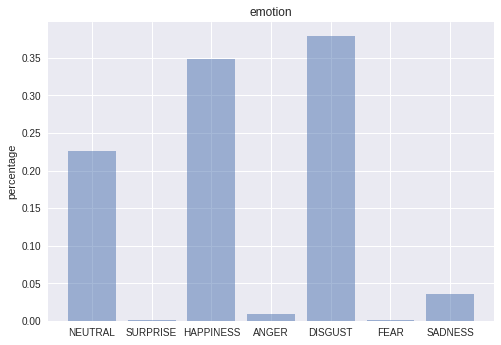

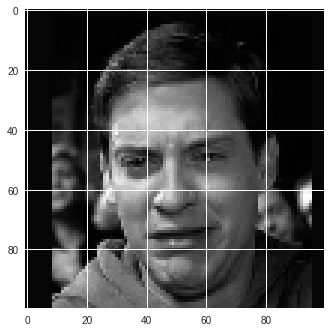

In [27]:
print("Scoring Happy")
score('/content/drive/My Drive/NewImagePrediction/John_Happy.jpg')

print("Scoring Angry")
score('/content/drive/My Drive/NewImagePrediction/Angry_Man.jpg')

print("Scoring Happy")
score('/content/drive/My Drive/NewImagePrediction/Happy_Face.jpg')

print("Scoring Sad")
score('/content/drive/My Drive/NewImagePrediction/Sad.jpg')

print("Scoring Angry")
score('/content/drive/My Drive/NewImagePrediction/jackie_angry.jpg')

print("Scoring Sad")
score('/content/drive/My Drive/NewImagePrediction/Tobey_Sad.jpg')